# Semantic Classification Using BERT

#### Setup

In [1]:
!pip install -q -U watermark

In [2]:
!pip install git+https://github.com/huggingface/transformers


  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-4vppwjak
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-4vppwjak
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.11.0+cu113
transformers: 4.20.0.dev0



In [4]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)


rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# 1A. Data Import

Importing the Data from CSV format, Removing any Labels that dont fit the binary class labels 1/0 format.

In [5]:
# Import CSV Data
import pandas as pd
import glob
"""
df_1 = pd.read_csv("data2/labelled-DentedFeels.csv"  , encoding='latin-1')
df_2 = pd.read_csv("data2/labelled-Degen-Toonz.csv" , encoding='latin-1')
df_3 = pd.read_csv("data2/labelled-Cosmic-Cats.csv" , encoding='latin-1')
df_4 = pd.read_csv("data2/labelled-Cosmodinos.csv" , encoding='latin-1')
"""

df_1 = pd.read_csv("data/labelled-DentedFeels.csv"  , encoding='latin-1')
df_2 = pd.read_csv("data/labelled-Degen-Toonz.csv" , encoding='latin-1')
df_3 = pd.read_csv("data/labelled-Cosmic-Cats.csv" , encoding='latin-1')
df_4 = pd.read_csv("data/labelled-Cosmodinos.csv" , encoding='latin-1')

# Separate the Training Examples
df_1 = df_1.dropna(axis=0, subset=['Label'])
df_2 = df_2.dropna(axis=0, subset=['Label'])
df_3 = df_3.dropna(axis=0, subset=['Label'])
df_4 = df_4.dropna(axis=0, subset=['Label'])

df_bert = pd.concat([df_1, df_2])
df_bert = pd.concat([df_bert, df_3])
df_bert = pd.concat([df_bert, df_4])
df_bert = df_bert[df_bert['Label'] != '-']



with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specifi
    #  print(df_bert['Label'])
    df_bert['Label'] = df_bert['Label'].astype(str).astype(float).astype(int)



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1B. Data Issues: Sampling Bias
- We accomodated for observer bias by measuring agreement for the labels between ourselves (two observers)


# 1B. Data Issues: Data imbalance
- Below shows the that there is an inbalance of 'bullish' i.e positvie sentiment class 1 training examples

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


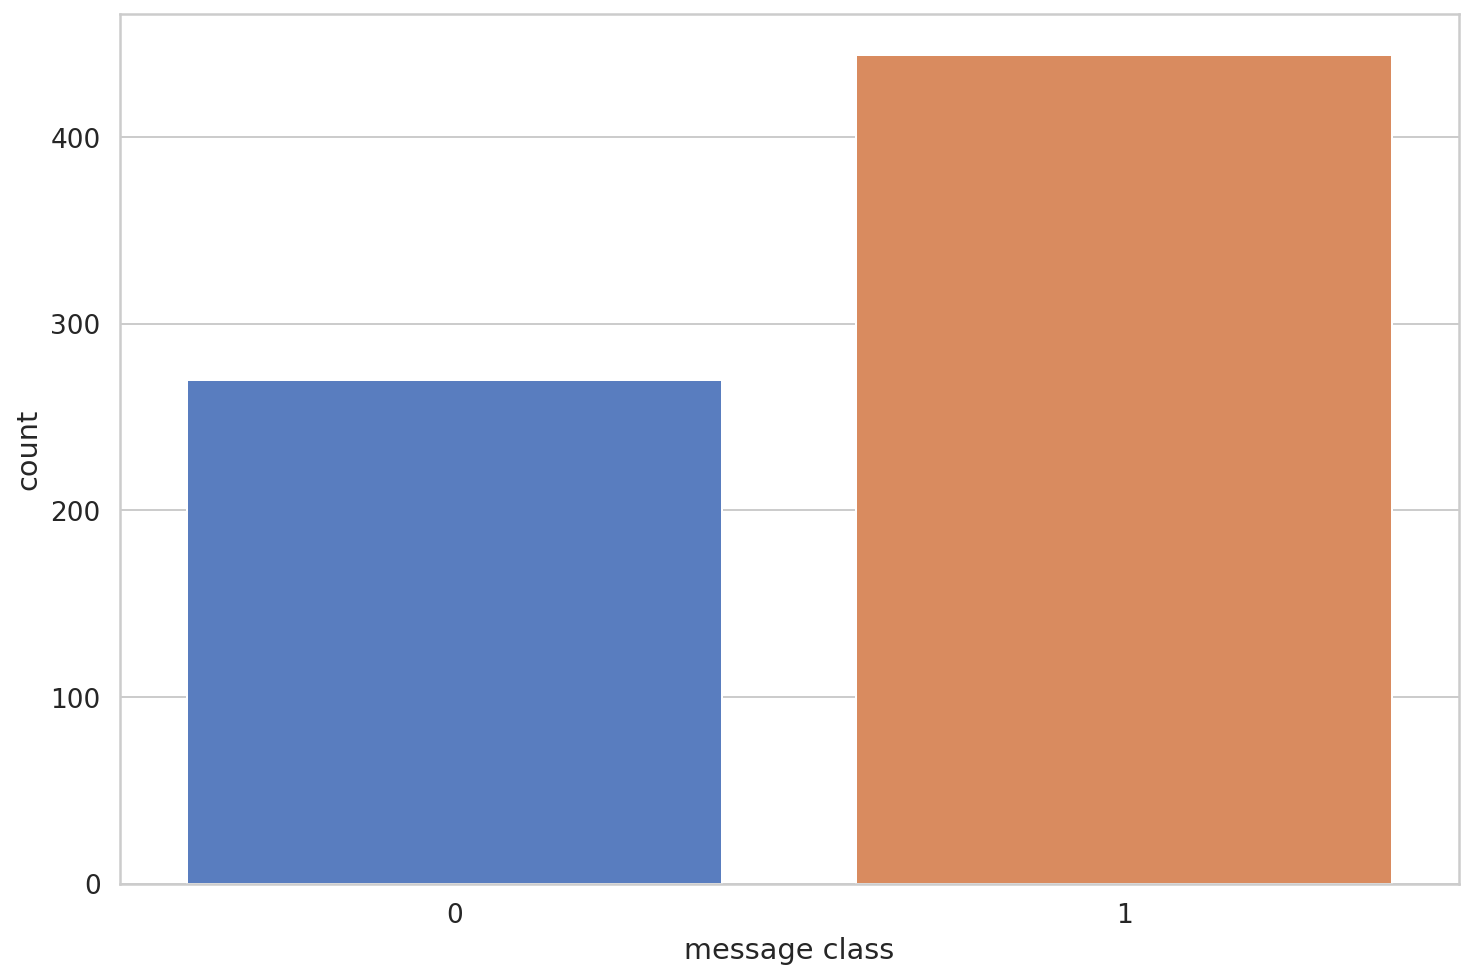

In [7]:
sns.countplot(df_bert.Label)
plt.xlabel('message class');


In [8]:
class_names = ['negative', 'positive']


# 1B. Data Issues: Data Reliabillity

- The reliablity of the data is unknown, although usernames are given, we did not investigate the usernames as many online profiles are anonmyous. The messages are from real chats, which were not aware they were being analysed. Therefore we have to trust that the data is representative of any other naturally occuring discord chatroom

# 1C. Data Preprocessing
- Tokenizer
- Case folding (Built into Bert Tokenizer)
- Stop words are often NOT removed as they imply context (negations), i.e BERT uses transformers that are based on "real and clean" text

Encoding which does -through using encode_plus():
- Adds [CLS] token at the beginning of the sentence
- Adds the [SEP] token at the end of the sentence
- Adds Padding to the sentence with [PAD] tokens so that the total length equals to the maximum length
- Tokens that were not in the training set, [UNK] (unknown) token.




In [9]:
# Load pretrained bert model, uncased as the data is to be folded
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,  return_dict=False)

sample_txt = 'The Volume is flying high we gonna moon'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: The Volume is flying high we gonna moon
   Tokens: ['the', 'volume', 'is', 'flying', 'high', 'we', 'gonna', 'moon']
Token IDs: [1996, 3872, 2003, 3909, 2152, 2057, 6069, 4231]


In [10]:
# Encoding
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=75,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# 2A. Soloution

### HyperParameter: Sequence Length
- Plot a distribution plot of all the training examples, to determine a safe max length
- Beacause BERT works with fixed-length sequence.
- Stored as token_lens
- = 75

In [11]:
# Initialise Array of Lengths
token_lens = []
df_content = df_bert['Content']
df_labels = df_bert['Label']

for txt in df_content:
    tokens = tokenizer.encode(txt, max_length=75)
    token_lens.append(len(tokens))
    
df_data = pd.concat([df_content, df_labels], axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


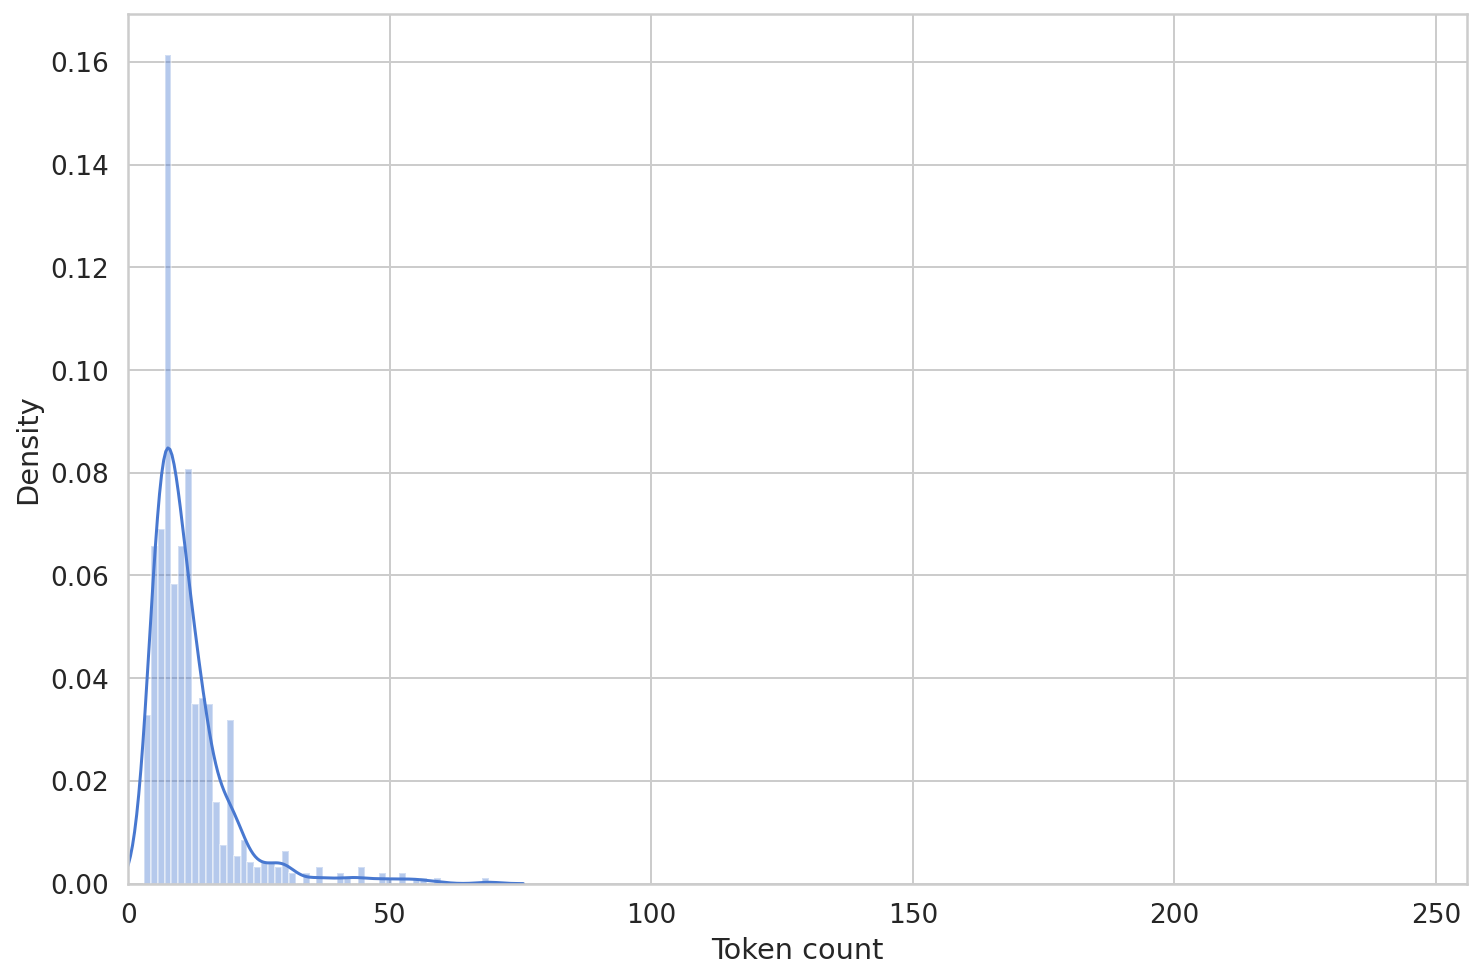

In [12]:
# Visualise the token lengths
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

**- From this Plot Above I have chosen to use 75 as the maximum token length.**

In [13]:
MAX_LEN = 75

### HyperParameter: Batch Size

In [14]:
BATCH_SIZE = 128

# 2A. Training Data Creation

The input dataframe is stored as df_data containing labels and content.

The following DiscordDataset()), takes in the messages, the labels and the tokenizer. It returns a dataloader with the keys 
- message_text
- input_ids
- attention_mask
- targets

In [15]:
class DiscordDataset(Dataset):
    def __init__(self, messages, targets, tokenizer, max_len):
        self.messages = messages
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.messages)
    
    def __getitem__(self, item):
        message = str(self.messages[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
          message,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
    )
        
        return {
      'message_text': message,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
        }

In [16]:
# Creates the data loaders (this is called per training/test/validation set)
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = DiscordDataset(
        messages=df.Content.to_numpy(),
        targets=df.Label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
      )

# 2B. KFOLD Cross Valdiation

In [17]:
"""# Sklearn KFOLD
import numpy as np
from sklearn.model_selection import KFold

# prepare cross validation
kfold = KFold(n_splits=3, shuffle=True, random_state=1)

# enumerate splits to train and test data
for train, test in kfold.split(df_data):       
    train_df = train_data.iloc[train_index]
    val_df = train_data.iloc[val_index]
"""

'# Sklearn KFOLD\nimport numpy as np\nfrom sklearn.model_selection import KFold\n\n# prepare cross validation\nkfold = KFold(n_splits=3, shuffle=True, random_state=1)\n\n# enumerate splits to train and test data\nfor train, test in kfold.split(df_data):       \n    train_df = train_data.iloc[train_index]\n    val_df = train_data.iloc[val_index]\n'

# 2B. Basic train Test split (For development)

In [18]:
df_train, df_test = train_test_split(
  df_data,
  test_size=0.3,
  random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

df_train.shape, df_val.shape, df_test.shape

((499, 2), (107, 2), (108, 2))

In [19]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Test that the keys/information within a random dataloader is ok.
data = next(iter(train_data_loader))
data.keys()


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['message_text', 'input_ids', 'attention_mask', 'targets'])

# 2C. BERT model Import

In [20]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [21]:
# Import the train model, with the correct number of output neurons (one for each class Bearish/Bullish)
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# 2D. BERT Hyperparameters
- Number of Epochs

The Optimal Number of epochs chosen was



- Optimizer: AdamW

Models trained with Adam have been observed to not generalize as well.
Furthermore, Weight decay tries to create networks with smaller weights as these can overfit less and generalize better. Because the number of steps = the number of training examples this is Stochastic Gradient Descent, as opposed to Batch or Mini Batch.

Default: Weight_decay (float, optional) – weight decay coefficient (default: 1e-2)


- Loss Function
 
 Cross entropy loss, it is preferred for classification over MSE.

- Learning Rate


Multiple models trained, loss & acc used to determine best value


- Scheduler

Warm up steps are steps with low learning rate at the beginning of training. 

Creates a schedule with a learning rate that decreases linearly from the initial lr.




In [22]:
# Hyperparameters
EPOCHS = 5
lr = 0.00002
# Implement the adam Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
loss_fn = nn.CrossEntropyLoss().to(device)

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=100
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# 2E. BERT model Training (Implementation)


In [23]:
def train_epoch(
      model,
      data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      n_examples
):
    # Switch to training mode
    model = model.train()
        
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        # Get the input data from the data loader, and the location of the padding, and labels.
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        # Calculate the Outputs
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Calculate the class prediction using Max
        _, preds = torch.max(outputs, dim=1)

        # Calculate Loss
        loss = loss_fn(outputs, targets)
        
        # Computer number of correct Predictions
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backpropagate the loss through the network
        loss.backward()

        # Clip the gradient to prevent exploding gradient
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Weight Decay
        optimizer.step()
        scheduler.step()

        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

# 2F. BERT model Validation (Implementation)

In [24]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    # Initialise params, switch to validation mode, As Backprop not used, this is just for monitoring not training
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            # Get the input data from the data loader, and the location of the padding, and labels.
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Calculate the Outputs
            outputs = model(
            input_ids=input_ids,
        attention_mask=attention_mask
      )
            
        # Calculate the class prediction using Max
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        # Calculate number of correct predictions
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

# 2G. Training Start/Call & Save Best Model

In [25]:
%%time
history = defaultdict(list)
best_accuracy = 0

# For every Epoch, calculate train accuracy and loss, and validation 
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)


  # Train and get the accuracy and loss
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
      )
    print(f'Train loss {train_loss} accuracy {train_acc}')


    # Validate
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
      )
    
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    # Store the values, to later on plot
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.6767729967832565 accuracy 0.5891783567134269


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Val   loss 0.6648954153060913 accuracy 0.5700934579439252

Epoch 2/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.6067202687263489 accuracy 0.6452905811623246


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Val   loss 0.6250624060630798 accuracy 0.6542056074766355

Epoch 3/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.45256220549345016 accuracy 0.7955911823647295


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Val   loss 0.6769899725914001 accuracy 0.6822429906542056

Epoch 4/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.28425925970077515 accuracy 0.8857715430861723


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Val   loss 0.6848352551460266 accuracy 0.7663551401869159

Epoch 5/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.17349371686577797 accuracy 0.9398797595190381


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Val   loss 0.914770245552063 accuracy 0.6915887850467289

CPU times: user 30min 5s, sys: 1min 17s, total: 31min 23s
Wall time: 31min 29s


In [48]:
torch.save(model.state_dict(), '80ACC_bert_state.bin')

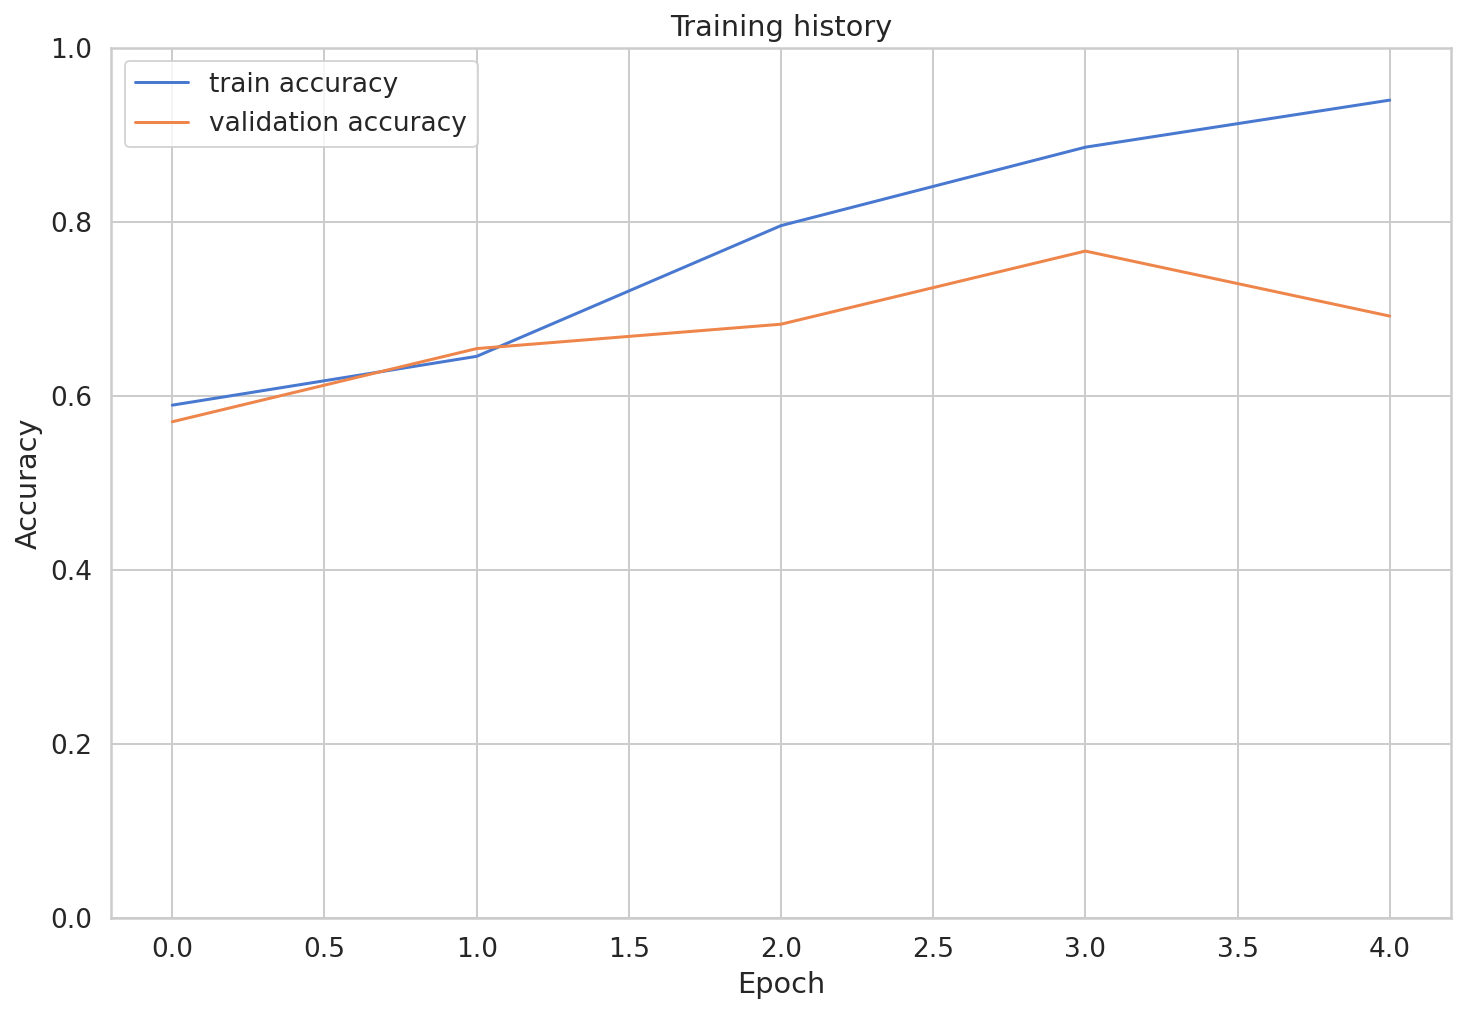

In [26]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

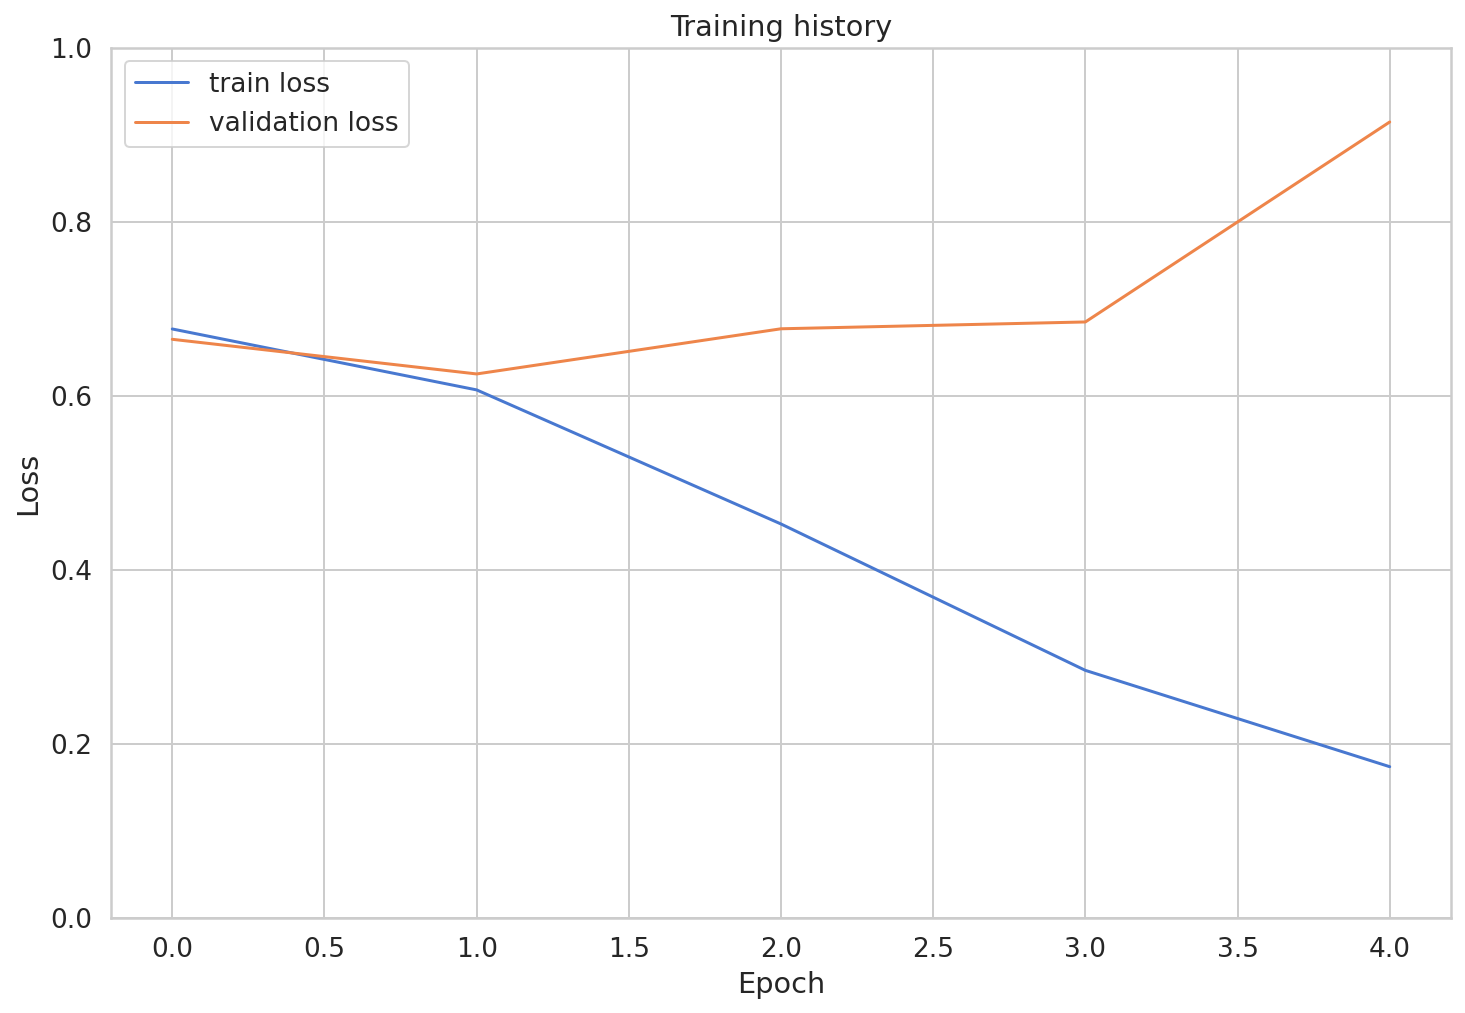

In [27]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

#3A Evaluation

In [28]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.7962962962962963

In [29]:
def get_predictions(model, data_loader):
    model = model.eval()
    message_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["message_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            message_texts.extend(texts)
            
            predictions.extend(preds)
        
            prediction_probs.extend(outputs)
            
            real_values.extend(targets)
        
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return message_texts, predictions, prediction_probs, real_values

In [30]:
y_message_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


#3B Evaluation Metrics: F1, RECALL, PRECISION, SUPPORT

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))



              precision    recall  f1-score   support

    negative       0.70      0.58      0.63        33
    positive       0.83      0.89      0.86        75

    accuracy                           0.80       108
   macro avg       0.77      0.73      0.75       108
weighted avg       0.79      0.80      0.79       108



Precision - (also called positive predictive value) is the fraction of relevant instances among the retrieved instances.

Recall - (also known as sensitivity) is the fraction of relevant instances that were retrieved


#3C Evaluation Metrics: CONFUSION MATRIX

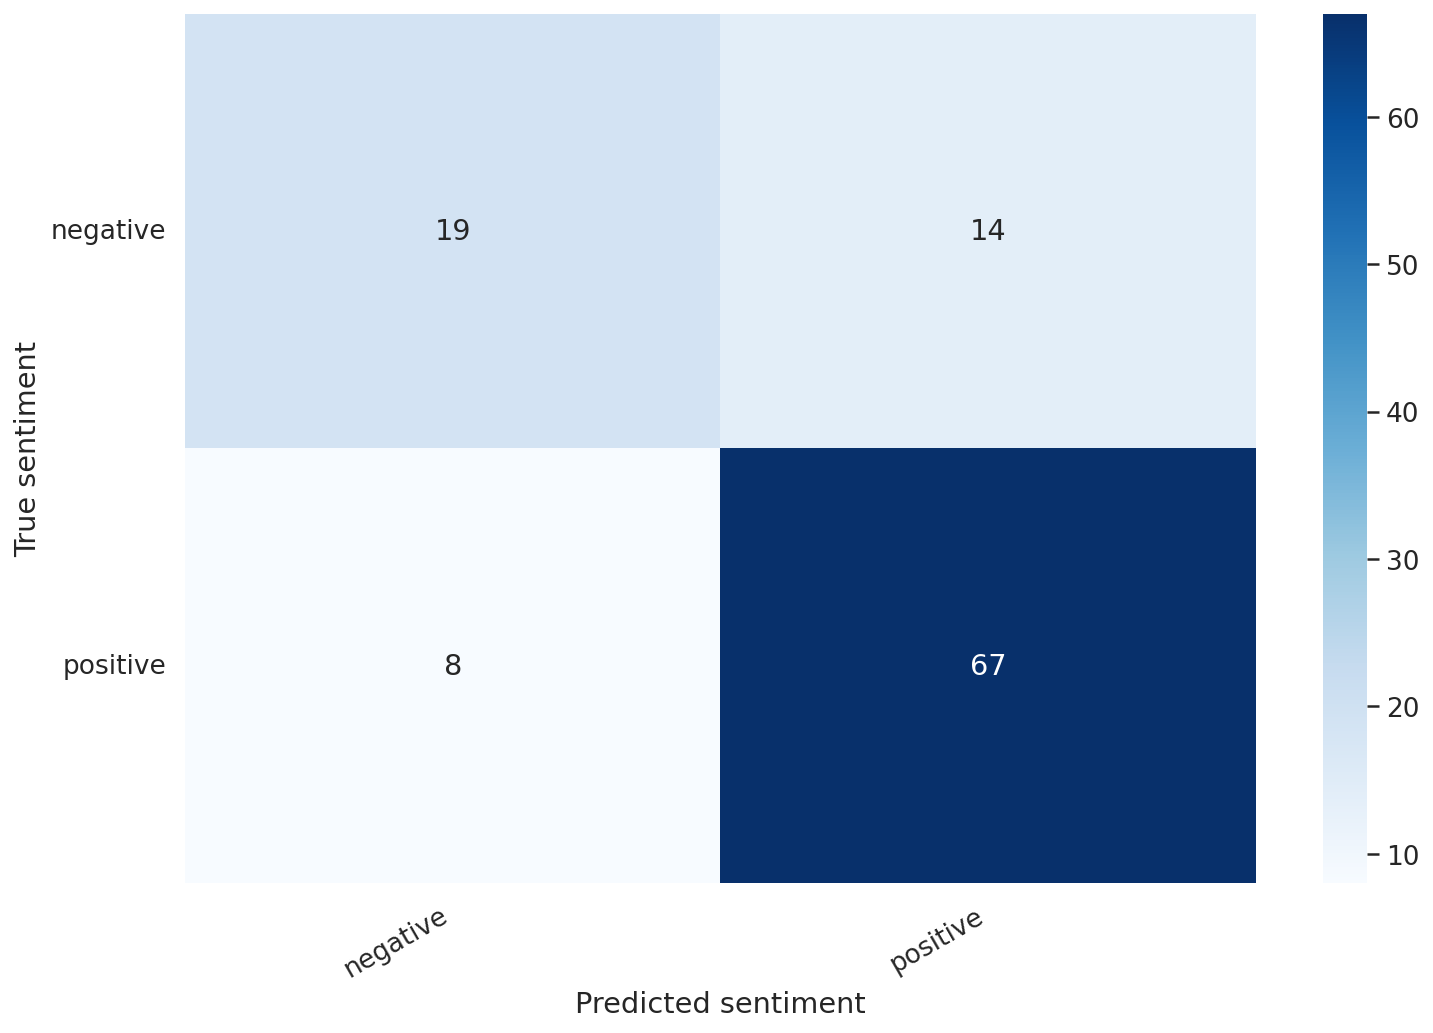

In [32]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
    
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Save Test Data

In [35]:
torch.save(test_data_loader, '80_dataloader.pth')

#### After Training Evaluation usin imported Test set or Raw Text & Obscure Examples

In [49]:
model = SentimentClassifier(len(class_names))
model = model.to(device)


model.load_state_dict(torch.load("/content/drive/MyDrive/TEAMPROJECT_NLU/Model_BERT/80ACC_bert_state.bin"))
model.eval()

test_data_loader = torch.load("/content/drive/MyDrive/TEAMPROJECT_NLU/Model_BERT/80_dataloader.pth")
len_test = 109


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [50]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len_test
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.7431192660550459

In [61]:
message = input("Enter message: ")


Enter message: WE going to the moon


In [62]:
encoded_message = tokenizer.encode_plus(
  message,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [70]:
input_ids = encoded_message['input_ids'].to(device)
attention_mask = encoded_message['attention_mask'].to(device)
output = model(input_ids, attention_mask)

p = output

_, prediction = torch.max(output, dim=1)

sm = torch.nn.Sigmoid()
probabilities = sm(output) 



print(f'Message text: {message}')
print(f'Predicted Status is: {class_names[prediction]}')
print(f'Probabillites for negative/positive are: {probabilities}')





Message text: WE going to the moon
Predicted Status is: positive
Probabillites for negative/positive are: tensor([[0.1985, 0.8387]], grad_fn=<SigmoidBackward0>)
